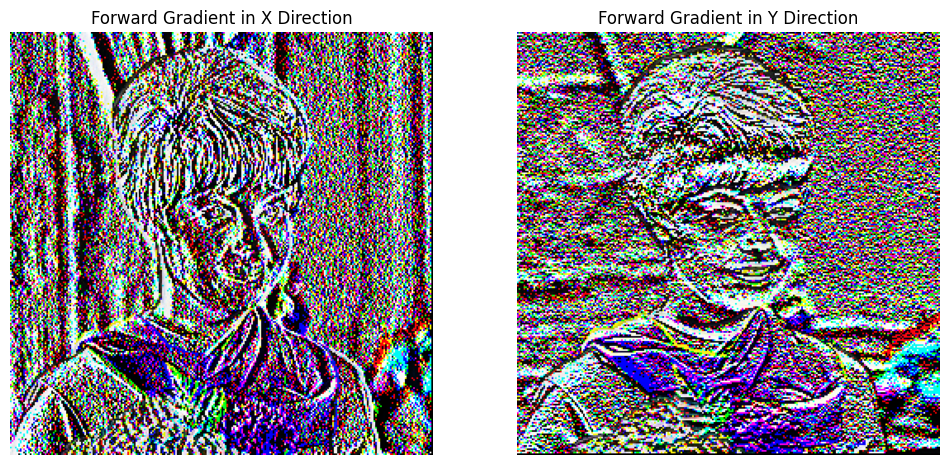

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from poisson_editing2 import *

image = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/girl.png')
grad_i,grad_j = im_fwd_gradient(image)
# Display the gradients
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Forward Gradient in X Direction')
plt.imshow(grad_i)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Forward Gradient in Y Direction')
plt.imshow(grad_j)
plt.axis('off')

plt.show()

In [2]:
src = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/girl.png')
dst = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/lena.png')
src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
print(src.shape,dst.shape)

(256, 256) (256, 256)


In [3]:
original_mask = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/mask_src_eyes.png', cv2.IMREAD_GRAYSCALE)   # Replace with actual original mask
translated_mask = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/mask_dst_eyes.png', cv2.IMREAD_GRAYSCALE)   # Replace with actual translated mask
offset = get_translation(original_mask, translated_mask)
print(offset)

(35, 10)


In [4]:
y_max, x_max = dst.shape
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min

M = np.float32([[1, 0, offset[1]], [0, 1, offset[0]]])
source = cv2.warpAffine(src, M, (x_range, y_range))
translated_image=source
print(translated_image.shape)

(256, 256)


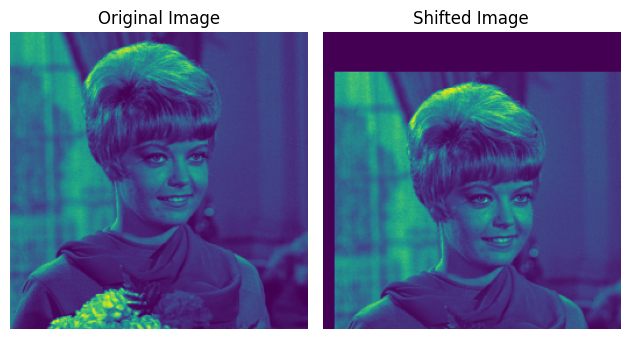

In [5]:
# Plotting the original and shifted images

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(src)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Shifted Image")
plt.imshow(translated_image)
plt.axis('off')

plt.tight_layout()
plt.show()

(70, 70)


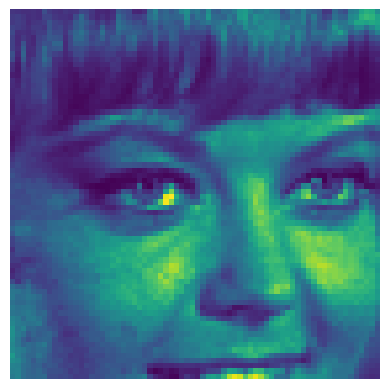

(70, 70)


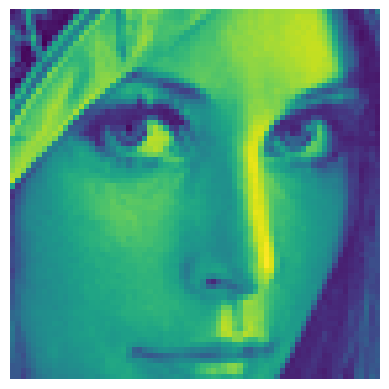

(70, 70)


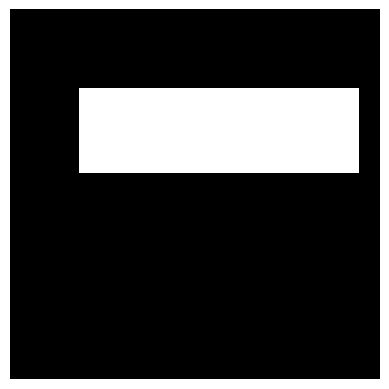

In [6]:
# Define the cropping box (y1:y2, x1:x2)
crop_box = translated_image[110:180, 110:180]  # Adjust these values as needed

print(crop_box.shape)
# Plot the cropped image
plt.imshow(crop_box)
plt.axis('off')  # Hide the axes
plt.show()

#####################################################################################
#Crop the target image too 
# Define the cropping box (y1:y2, x1:x2)
crop_box_dst = dst[110:180, 110:180] # Adjust these values as needed

print(crop_box_dst.shape)
# Plot the cropped image
plt.imshow(crop_box_dst)
plt.axis('off')  # Hide the axes
plt.show()
#################################################################################
#Crop the mask 
crop_box_mask = translated_mask[110:180, 110:180]  # Adjust these values as needed
converted_mask = np.where(crop_box_mask == 255, 1, crop_box_mask)
print(converted_mask.shape)
# Plot the cropped image
plt.imshow(converted_mask,cmap='gray')
plt.axis('off')  # Hide the axes
plt.show()

In [9]:
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt

# Initialize combined image and mask
combined_image = np.zeros_like(crop_box_dst)
mask_flat = converted_mask.flatten()

# Calculate beta based on the mask
beta_0 = 1
beta = beta_0 * (1 - mask_flat)
B = np.diag(beta)

# Extract dimensions
y_min, y_max = 0, crop_box_dst.shape[0]
x_min, x_max = 0, crop_box_dst.shape[1]
y_range, x_range = y_max - y_min, x_max - x_min

# Flatten the source and target images
source_flat = crop_box.flatten()
target_flat = crop_box_dst.flatten()

# Compute gradients
vi, vj = composite_gradients(crop_box, crop_box_dst, converted_mask)

# Generate the Laplacian matrix and Poisson operator
A = poisson_linear_operator(combined_image, B) @ combined_image.flatten()
print("Laplacian matrix A shape:", A.shape)

# Compute the divergence
divergence = im_bwd_divergence(vi, vj).flatten()

# Create b considering beta and divergence
b = np.dot(B, target_flat) - divergence
print("b values (min, max):", np.min(b), np.max(b))

# Solve for x
x = spsolve(A, b.flatten())
print("Solution x:", x)
print("Min x value:", np.min(x), "Max x value:", np.max(x))

# Recompute divergence for debugging
divergence = im_bwd_divergence(vi, vj).flatten()
print("Divergence values (min, max):", np.min(divergence), np.max(divergence))
print("Target flattened values (min, max):", np.min(target_flat), np.max(target_flat))
print("Beta values (min, max):", np.min(beta.flatten()), np.max(beta.flatten()))

# Ensure pixel values are within valid range
x = np.clip(x, 0, 255).astype('uint8')

# Reshape x to match the dimensions of the target region
x_reshaped = x.reshape((y_range, x_range))

# Assign the result to the combined image
combined_image[y_min:y_max, x_min:x_max] = x_reshaped

OverflowError: Python integer -4 out of bounds for uint8

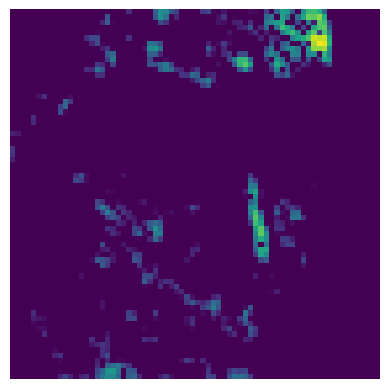

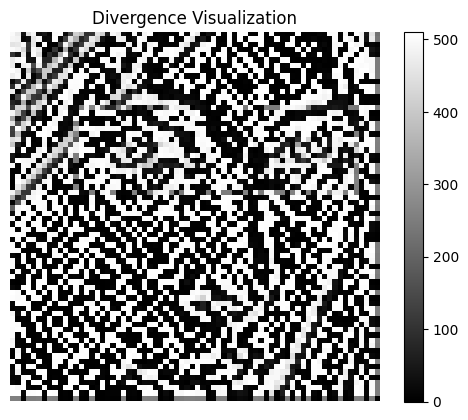

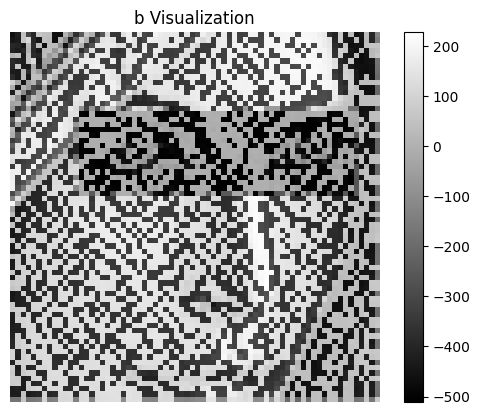

In [39]:
    # Display the resulting grayscale image
plt.imshow(combined_image)
plt.axis('off')
plt.show()
plt.imshow(divergence.reshape((y_range, x_range)), cmap='gray')
plt.title('Divergence Visualization')
plt.colorbar()
plt.axis('off')
plt.show()

plt.imshow(b.reshape((y_range, x_range)), cmap='gray')
plt.title('b Visualization')
plt.colorbar()
plt.axis('off')
plt.show()

In [18]:
import numpy as np
from scipy.optimize import minimize

# Initialize combined image
u_comb = np.zeros_like(crop_box_dst)  # Combined image
m = crop_box_mask

# Extract dimensions
y_max, x_max = crop_box_dst.shape[:-1]
y_min, x_min = 0, 0

def E(u, A, b, c):

    """Calculate the energy value."""
    u = np.array(u)
    energy_value = 0.5 * np.dot(u, A @ u) - np.dot(b, u) + c.item() # Ensure c is a scalar
    return energy_value  # Ensure it's a scalar

# Assuming mask, u_comb, dst, src, and poisson_editing are defined
final_result = np.zeros_like(u_comb)

# Iterate over each color channel
for channel in range(3):
    u = u_comb[:, :, channel]
    u2 = crop_box_dst[:, :, channel]
    u1 = crop_box[:, :, channel]
    plt.imshow(u)

    plt.show()
    plt.imshow(u1)
    plt.show()
    plt.imshow(u2)
    plt.show()
    beta_0 = 1
    beta = beta_0 * (1 - m)

    # Compute gradients and matrices
    vi, vj = compute_composite_gradient(u1, u2, m)
    A = poisson_linear_operator(u, beta)
    
    # Now create b
    b = (beta * u2) - im_bwd_divergence(vi, vj)

    v = np.array([vi, vj])
    c = 0.5 * np.sum(v ** 2) + 0.5 * np.sum(beta * u2 ** 2)

    shape = u.shape

    # Optimize using L-BFGS-B
    result = minimize(E, u.flatten(), args=(A, b.flatten(), c), method='L-BFGS-B')

    # Reshape to original dimensions and store the result
    optimal_u = result.x.reshape(shape)
    u_comb[:, :, channel] = optimal_u

# Final combined result
u_final = u_comb


error: OpenCV(4.10.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x46dff480::Set<1,-1,-1>,struct cv::impl::A0x46dff480::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


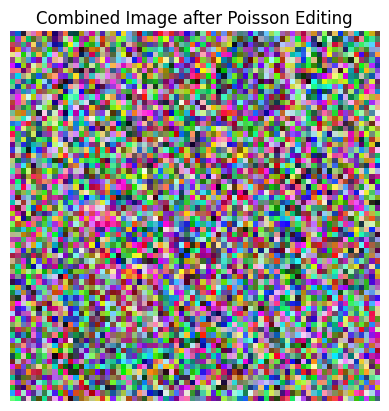

In [16]:
# Plotting
plt.imshow(u_comb)  # Use imshow to display the image
plt.axis('off')  # Turn off axis
plt.title("Combined Image after Poisson Editing")
plt.show()